## EDA and Data Preprocessing

According to the README.md from https://github.com/zalandoresearch/fashion-mnist, we can use this function from Tensorflow to load the dataset. And it's already split for us.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"tensorflow version: {tf.__version__}")
(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

2024-10-26 20:47:08.635191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 20:47:09.980922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version: 2.13.0


In [2]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


It would be more convenient to have the image as a flat vector, i.e. a 784-dimension Numpy array.

In [2]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

Let's have a look at some image.

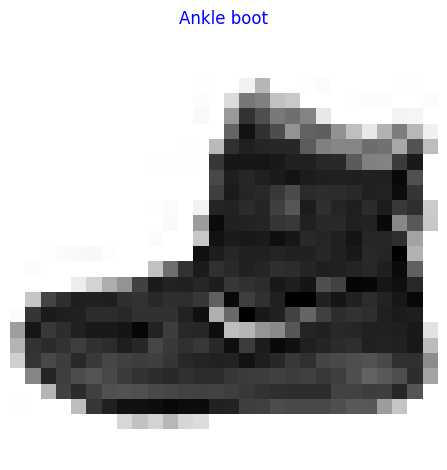

In [19]:
class_name = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

def plot_image(image_data: np.ndarray, label:int):
    image_data = image_data.reshape(28, 28)
    plt.imshow(image_data, cmap="binary")
    plt.title(class_name[label], color = "blue")
    plt.axis("off")
    plt.tight_layout()

plot_image(X_train[0], y_train[0])
plt.show()

An image doesn't tell very much though. Let's have a peek at the first 64 images from the train set.

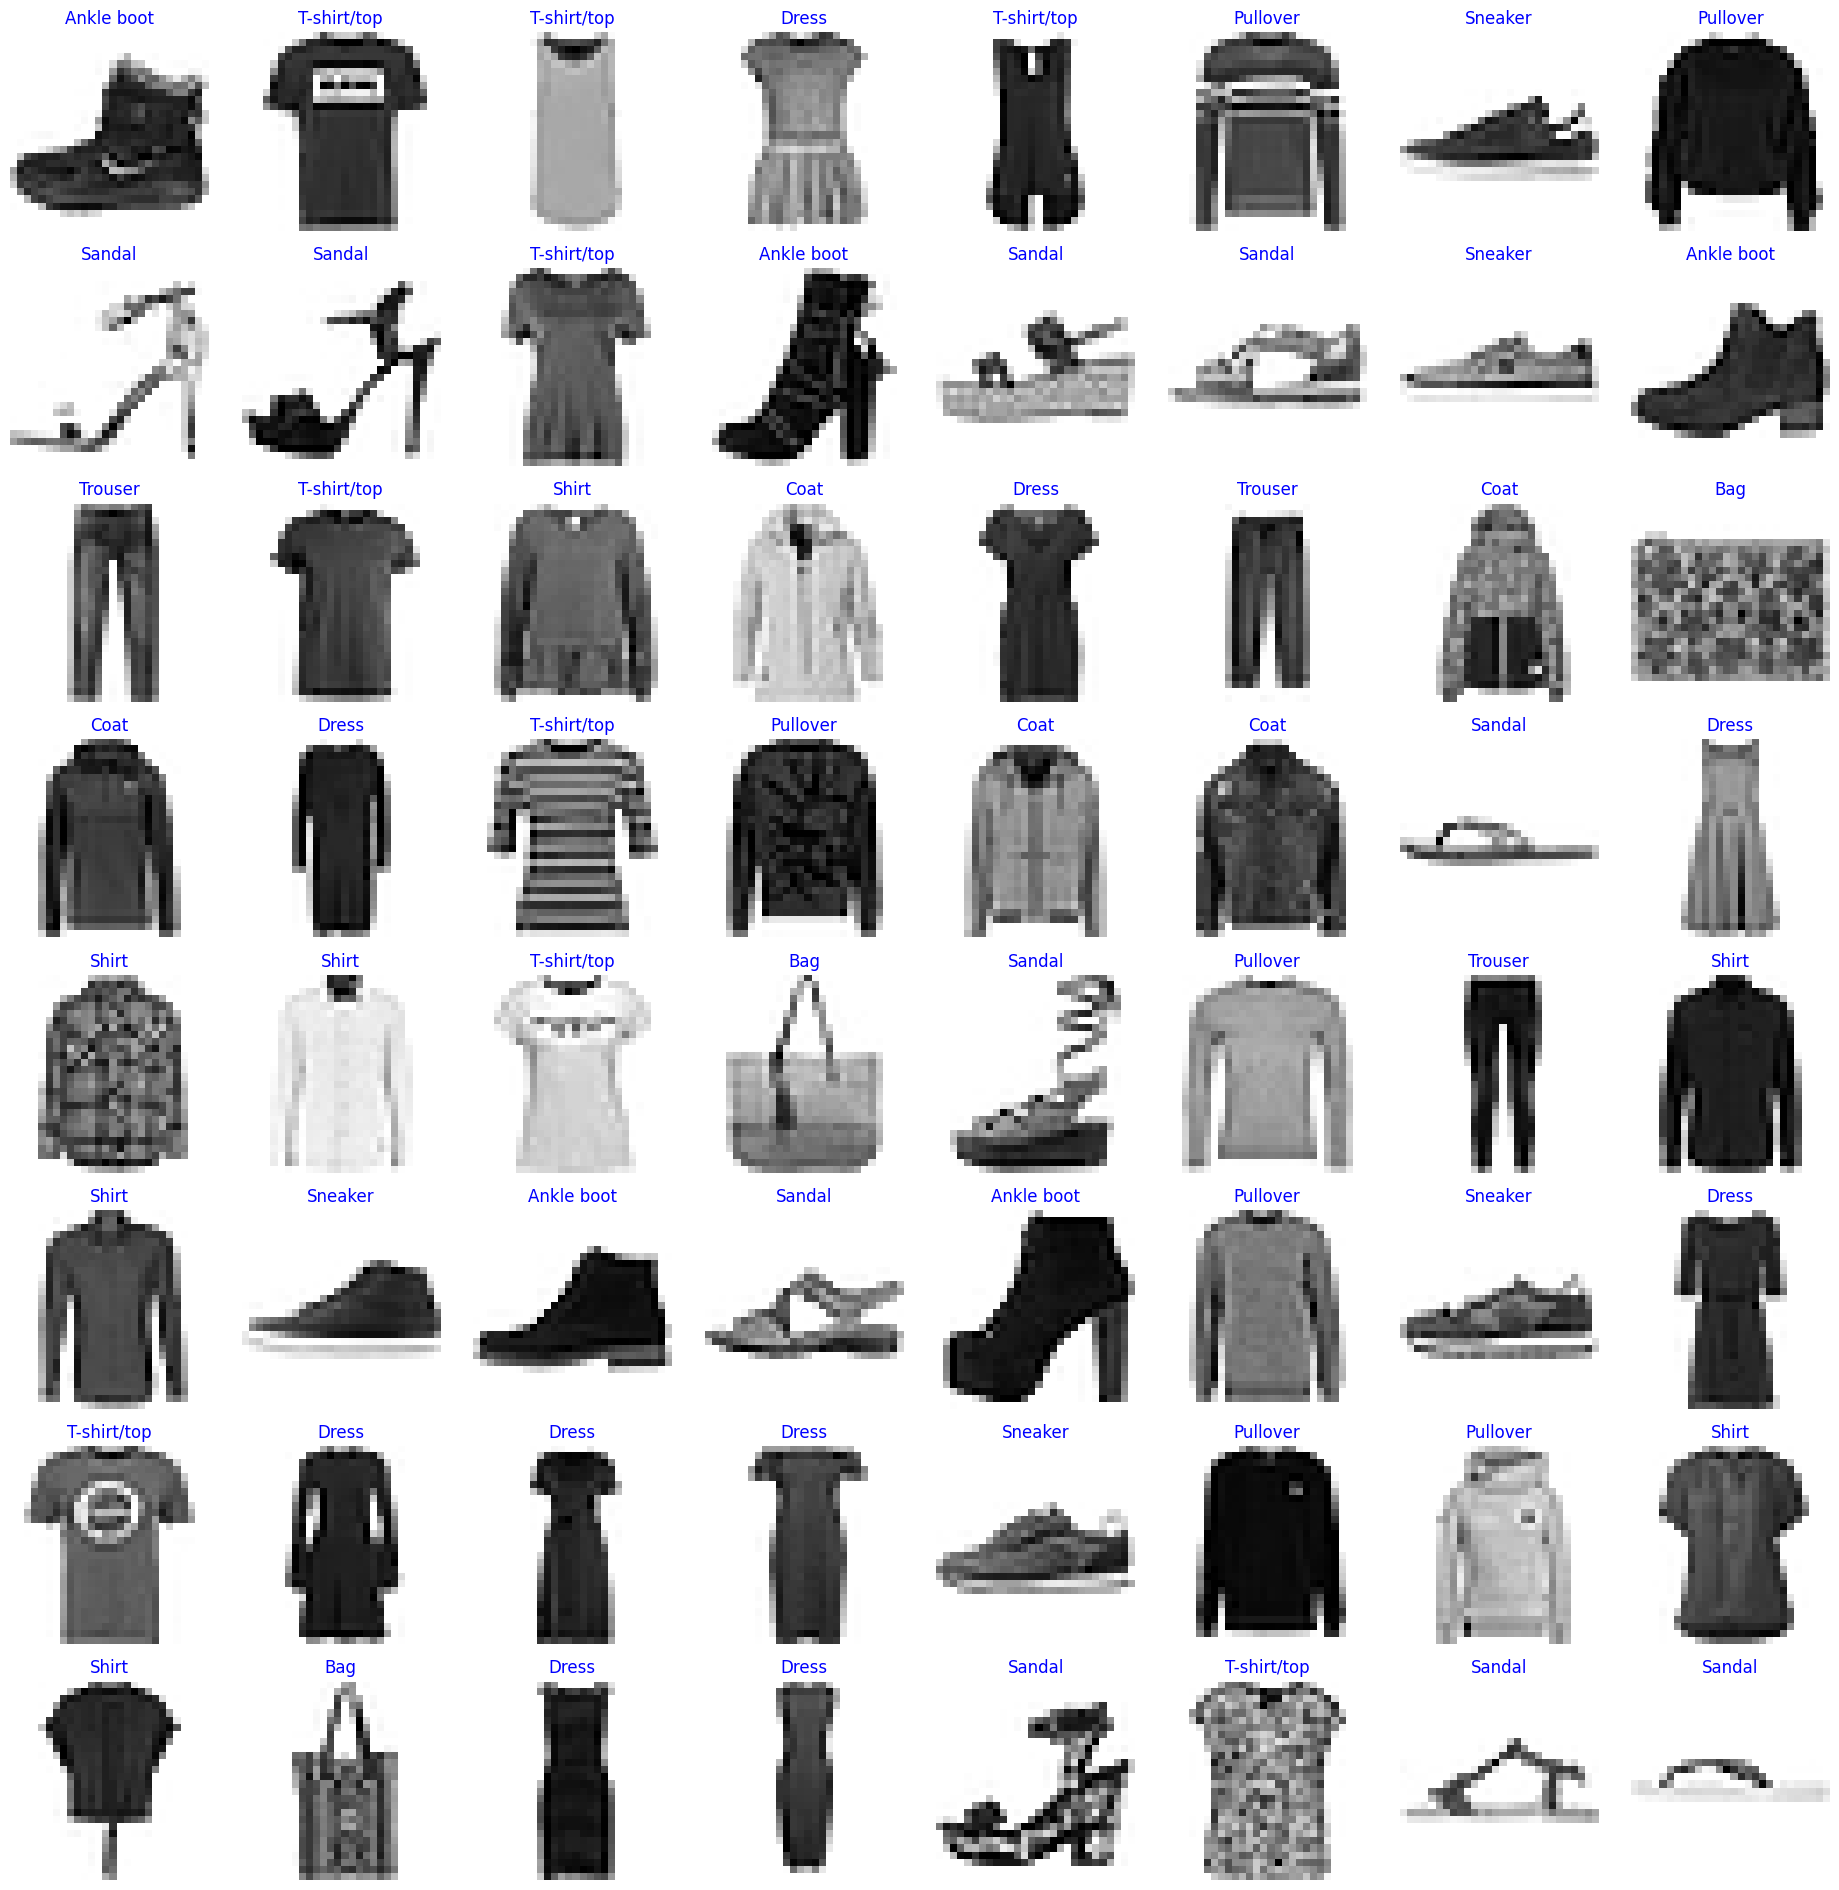

In [5]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(19, 19))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index], y_train[index])

plt.show()

From their documentation, the data is already cleaned for us, so no image preprocessing is required (I don't think I'm better than the expert at this).

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

There are ten classes, with the exact same amount across all of them in both train and test set.
Here are the class names and their corresponding indices:

| Index | Class Name    |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

In [3]:
# Optionally, here are the scaled version of the X sets, though I think you shouldn't use it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## Train Linear Model - Logistic Regression

Training with native logistic regression first

In [9]:
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=10000)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

# do cross-validation with cuml LogisticRegression
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    log_reg.fit(X_train_fold, y_train_fold)
    
    y_pred = log_reg.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

print(f"Accuracy of cuML logistic regression: {np.mean(accuracies):.2f}")


Accuracy of cuML logistic regression: 0.84


## Tuning Logistic Regression Model

I use `GridSearchCV` to search the best.

Parameters will be fine tune are:
- `C`: regularization, because it helps prevent **overfiting**, if it too small, model will be overfit, otherwise model will be underfit.

In [6]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solvers = ['qn'] # 'qn' is equal to 'newton-cg' of scikit-learn
best_accuracy = 0
best_params = {}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for C in C_values:
    for solver in solvers:
        accuracies = []
        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # init model with hyper params
            model = LogisticRegression(C=C, solver=solver, max_iter=10000) # max_iter to make sure that model converged
            
            # train model
            model.fit(X_train_fold, y_train_fold)
            
            
            # predict on valid
            y_pred = model.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_pred)
            accuracies.append(accuracy)
        
        # calculate mean accuracy
        avg_accuracy = np.mean(accuracies)
        print(f"Parameters: C={C}, solver={solver} => Accuracy: {avg_accuracy:.2f}")
        
        # update params if these are better 
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'C': C, 'solver': solver}

print("\nBest parameters:", best_params)
print("Best accuracy:", best_accuracy)

Parameters: C=0.001, solver=qn => Accuracy: 0.85
Parameters: C=0.01, solver=qn => Accuracy: 0.86
Parameters: C=0.1, solver=qn => Accuracy: 0.85
Parameters: C=1, solver=qn => Accuracy: 0.84
Parameters: C=10, solver=qn => Accuracy: 0.83
Parameters: C=100, solver=qn => Accuracy: 0.83
Parameters: C=1000, solver=qn => Accuracy: 0.83

Best parameters: {'C': 0.01, 'solver': 'qn'}
Best accuracy: 0.8568166666666667


## Evaluate Logistic Regression Model

Train all training data, then evaluate on test set with metrics

Metrics:
- Accuracy
- Precision
- Recall
- F1 Score

In [13]:
import pickle

best_logistic_regression = LogisticRegression(**best_params, max_iter=10000)
best_logistic_regression.fit(X_train_scaled, y_train) # the whole data set

# Save the model to a file
with open("cuml_logistic_regression_model.pkl", "wb") as f:
    pickle.dump(best_logistic_regression, f)

y_pred_log_reg = best_logistic_regression.predict(X_test_scaled)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc_score = accuracy_score(y_test, y_pred_log_reg)
prec_score = precision_score(y_test, y_pred_log_reg, average='macro')
rec_score = recall_score(y_test, y_pred_log_reg, average='macro')
f1 = f1_score(y_test, y_pred_log_reg, average='macro')

print(f"Accuracy on test set: {acc_score:.2f}")
print(f"Precision score on test set: {prec_score:.2f}")
print(f"Recall score on test set: {rec_score:.2f}")
print(f"f1 score on test set: {f1:.2f}")

Accuracy on test set: 0.85
Precision score on test set: 0.85
Recall score on test set: 0.85
f1 score on test set: 0.85


In [15]:
cm = confusion_matrix(y_test, y_pred_log_reg)

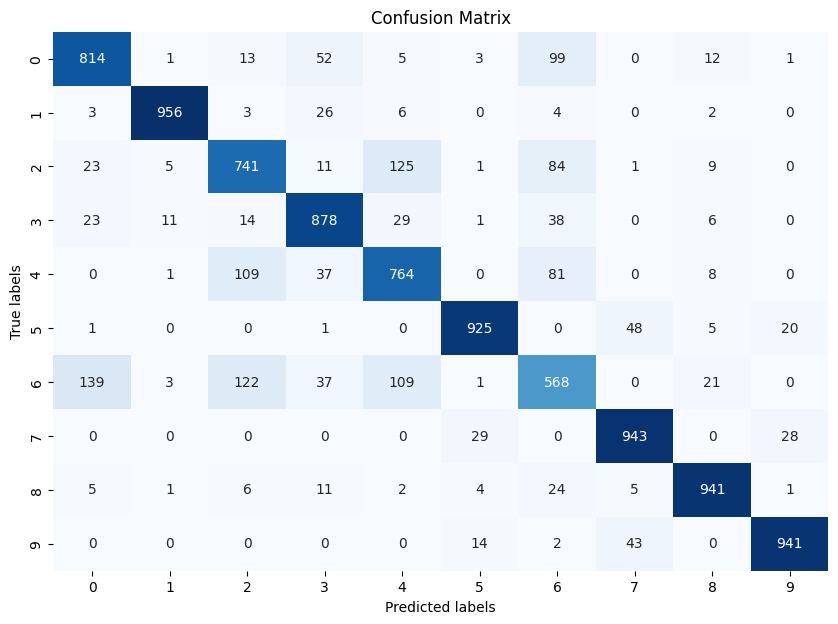

In [16]:
# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar = False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Discuss about Logistic Regression with observed patterns

In [17]:
wrong_indexes = np.where(y_test != y_pred_log_reg)[0]
print(f"There are {len(wrong_indexes)} wrong predicted cases")

There are 1529 wrong predicted cases


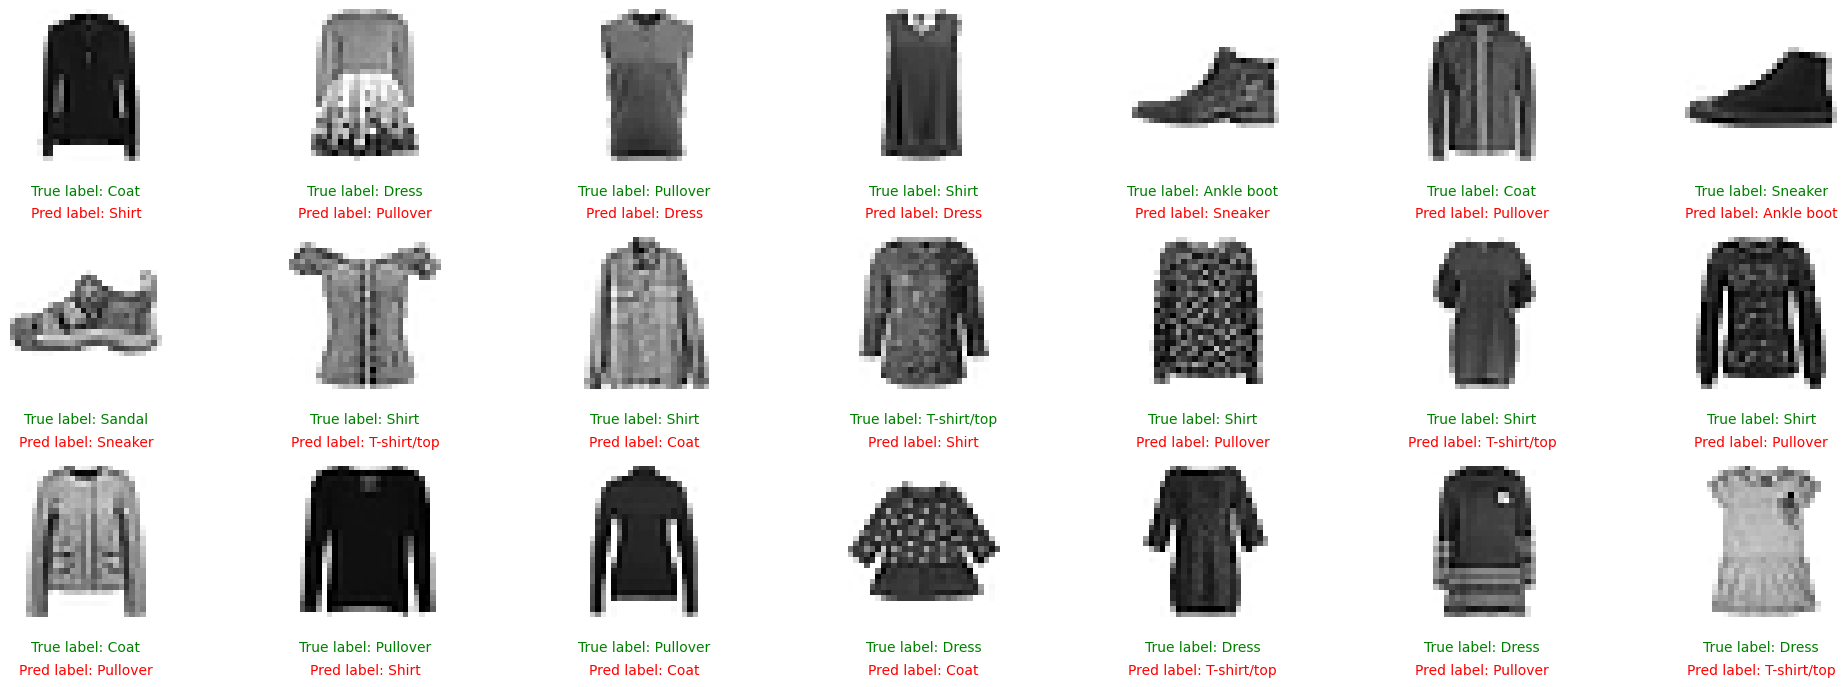

In [20]:
N = 21
random_indexes = np.random.choice(wrong_indexes, size=N, replace=False)
plt.figure(figsize=(20, 7))
n_cols = 7
n_rows = int(np.ceil(N/n_cols))


for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        if index < N:
            plt.subplot(n_rows, n_cols, index + 1)
            image_index = random_indexes[index]
            right_label = y_test[image_index]
            wrong_label = y_pred_log_reg[image_index]
            image_data = X_test[image_index].reshape(28, 28)
            plt.imshow(image_data, cmap="binary")
            plt.axis("off")

            plt.text(
                0.5, -0.15, f"True label: {class_name[right_label]}", color="green", ha="center", va="top", transform=plt.gca().transAxes
            )
            plt.text(
                0.5, -0.3, f"Pred label: {class_name[wrong_label]}", color="red", ha="center", va="top", transform=plt.gca().transAxes
            )

plt.tight_layout()
plt.show()

**1. Similar Shape and Silhouette:**
- The model often misclassifies items with similar shapes or silhouettes, such as "T-shirt/top" as "Shirt" and "Pullover" as "Shirt." These types of clothing items share a similar outline, which can be hard to distinguish in grayscale or low-resolution images, as the model may struggle to capture subtle differences in collar shape, sleeve length, or fabric texture.

**2. Confusion between Clothing Categories:**

- Instances of "Dress" are often predicted as "Coat" or "T-shirt/top." Dresses and coats can sometimes have similar lengths and shapes, particularly when rendered in grayscale, making it challenging for the model to differentiate between these items without additional color or texture information.

**3. Accessory and Clothing Misclassification:**

- There are examples where items like "Bag" and "Shirt" are confused, likely due to the presence of rectangular shapes in bags that can resemble certain shirt outlines in low-resolution images. This type of error suggests that the model may need to learn more specific features related to accessories versus apparel to avoid such confusion.
    
**4. Footwear Confusion:**

- The model occasionally mistakes "Sneaker" for "Sandal," possibly because both share similar shapes, especially in simplified images. This error suggests that the model might not be fully capturing unique footwear characteristics, like the open design of sandals versus the closed structure of sneakers.